## Lecture 16 of CMU16-745 (2025)

#### py_quadrotor.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve,norm, inv, matrix_rank
from scipy.linalg import block_diag
from pydrake import forwarddiff
import control as ctl

<hr>

The function definitions in the cell below are the same as in lecture 15, with additional rptoq(), qtorp()

In [2]:
def hat(v):
    return np.array([[0,-v[2],v[1]],
                     [v[2],0,-v[0]],
                     [-v[1],v[0],0]])

def L(q):
    global s,v,L_u,L_l
    s = q[0]
    v = q[1:]
    L_u = np.hstack((np.expand_dims(s,axis=0),-v.T))
    L_l = np.hstack((v.reshape(3,1),s*np.eye(3) + hat(v.flatten()))) # add v.reshape()
    return np.vstack((L_u,L_l))

# This has conflict with cost weight R-matrix
# def R(q):
#     global R_u, R_l,s,v
#     s = q[0]
#     v = q[1:]
#     R_u = np.hstack((np.expand_dims(s,axis=0),-v.T))
#     R_l = np.hstack((v.reshape(3,1),s*np.eye(3) - hat(v.flatten()))) # add v.reshape()
#     return np.vstack((R_u,R_l))

T = np.diagflat([1,-1,-1,-1])
H = np.vstack((np.zeros((1,3)),np.eye(3)))

def G(q):
    return L(q)@H

def qtoQ(q):
    return H.T@T@L(q)@T@L(q)@H 
#    return H.T@(R(q).T@L(q))@H

# added in this lecture
def rptoq(phi):
    q = (1/np.sqrt(1+phi.T@phi))*np.vstack((1,phi))
    return q

def qtorp(q):
    return q[1:4]/q[0]

In [3]:
def vec(Mat):
    global M_global
    M_global = Mat
    m, n = np.shape(Mat)[0], np.shape(Mat)[1]
    return np.reshape(Mat,(m*n,1), order='F')

<hr>

In [4]:
#Quadrotor parameters
m = 0.5
l = 0.1750
J = np.diagflat([0.0023, 0.0023, 0.004])
g = 9.81
kt=1.0
km=0.0245

h = 0.05 #20 Hz
Nx = 13     # number of states (quaternion)
Nx_tilde = 12 # number of states (linearlized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time 
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt-1),h)

In [5]:
def E(q):
    E = block_diag(np.eye(3),G(q),np.eye(6))
    return E

In [6]:
# test E matrix
# q = np.random.randn(4,1)
# q = q/norm(q)
# Emat = E(q)

In [7]:
# quadrotor dynamics
def quad_dynamics(x,u):
    global r_dot, q_dot,_v_dot,w_dot,Z, u_cv
    u_cv = u.reshape(4,1) # reshape u to column vector
    r = x[0:3].reshape(3,1)
    q = x[3:7]/norm(x[3:7]) # normalize q just to be careful
    v = x[7:10].reshape(3,1)
    w = x[10:13].reshape(3,1)
    Q = qtoQ(q)

    r_dot = Q@v
    q_dot = 0.5*L(q)@H@w
    w_flat = w.flatten()
    v_dot  = (Q.T@np.array([[0],[0],[-g]]) + 
              (1/m)*np.vstack((np.zeros((2,4)),kt*np.ones(([1,4]))))@u_cv -
              hat(w_flat)@v)
    lkt = l*kt
    Z = (-hat(w_flat)@J@w  + np.array([[0,lkt,0,-lkt],[-lkt,0,lkt,0],[km,-km,km,-km]])@u_cv)  
    w_dot = inv(J)@Z
    x_new = np.vstack((r_dot,q_dot, v_dot, w_dot))
    return x_new

    

In [8]:
def quad_dynamics_rk4(x,u):
    #RK4 integration with zero-order hold on u
    global f1, f2, f3, f4,x_a,x_2,xn
    xdim = x.shape[0]
    f1 = quad_dynamics(x,u)
    x_a = x.reshape(xdim,1)
    x_2 = x_a + 0.5*h*f1
    f2 = quad_dynamics(x_2.flatten(),u)
    x_3 = x_a + 0.5*h*f2
    f3 = quad_dynamics(x_3.flatten(),u)
    x_4 = x_a + 0.5*h*f3
    f4 = quad_dynamics(x_4.flatten(),u)
    xn = x_a + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[3:7] = xn[3:7]/norm(xn[3:7]) # re-normalize quaternion    
    return xn

In [9]:
# wrapper for Drake
def quad_rk4_x(x):
    # global u_global 
    return quad_dynamics_rk4(x, u_global)

def quad_rk4_u(u):
    # global x_global 
    return quad_dynamics_rk4(x_global.flatten(), u)    

def dfdx(x,u):
    global u_global
    u_global = u
    y = np.squeeze(forwarddiff.jacobian(quad_rk4_x,x.flatten()))
    return y

def dfdu(x,u):
    global x_global
    x_global = x
    y = np.squeeze(forwarddiff.jacobian(quad_rk4_u,u.flatten()))    
    return y

In [10]:
# initial conditions
u_hover = (m*g/4)*np.ones((4,1))
r0 = np.array([0,0,1.0]).reshape(3,1)
q0 = np.array([1.0,0,0,0]).reshape(4,1)
v0 = np.zeros((3,1))
w0 = np.zeros((3,1))
x0 = np.vstack((r0,q0,v0,w0))

In [11]:
#Linearize dynamics about hover
A = dfdx(x0, u_hover)
B = dfdu(x0, u_hover)

In [12]:
matrix_rank(A)

np.int64(12)

In [13]:
matrix_rank(ctl.ctrb(A,B))

np.int64(12)

In [14]:
# reduced system
A_tilde = E(q0).T@A@E(q0)
B_tilde = E(q0).T@B

In [15]:
matrix_rank(ctl.ctrb(A_tilde,B_tilde))

np.int64(12)

In [16]:
# cost weights
Q = np.eye(Nx_tilde)
R = 0.1*np.eye(Nu)

In [17]:
K,_,_ = ctl.dlqr(A_tilde,B_tilde,Q,R)

In [18]:
# feedback controller
def controller(x):
    global phi,delx_tilde
    q0 = x0[3:7].reshape(4,1)
    q = x[3:7].reshape(4,1)
    phi = qtorp(L(q0).T@q)
    rc = x[0:3].reshape(3,1)
    vc = x[7:10].reshape(3,1)
    wc = x[10:13].reshape(3,1)

    delx_tilde = np.vstack((rc-r0,phi,vc-v0,wc-w0))
    u = u_hover - K@delx_tilde
    return u

In [19]:
# simulation
uhist = np.zeros((Nu,Nt))
xhist = np.zeros((Nx,Nt))
xr0 = r0 + np.random.rand(3,1)
xq0 = L(q0)@rptoq(np.array([1,0,0]).reshape(3,1))
xhist[:,[0]] = np.vstack((xr0,xq0,v0,w0))
for k in range(Nt-1):
    uhist[:,[k]] = controller(xhist[:,k])
    xhist[:,[k+1]] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])


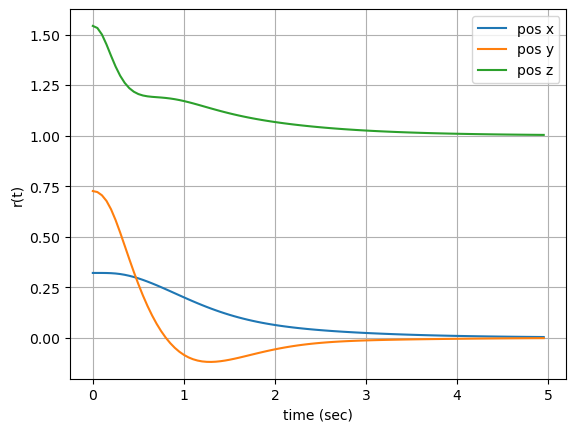

In [20]:
plt.figure()
plt.plot(thist,xhist[0:3,:-1].T)
plt.xlabel('time (sec)')
plt.ylabel('r(t)')
plt.legend(['pos x','pos y','pos z'])
plt.grid(True)
plt.show()

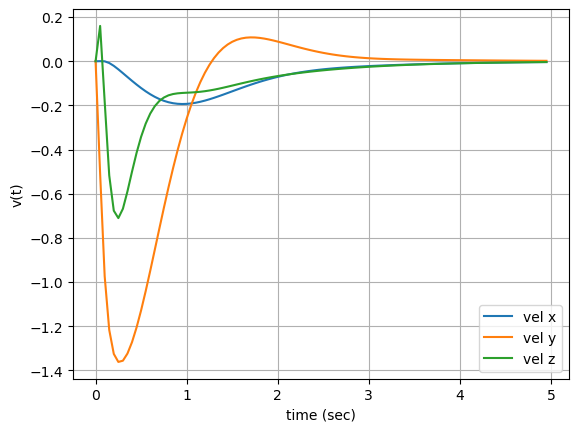

In [21]:
plt.figure()
plt.plot(thist,xhist[7:10,:-1].T)
plt.xlabel('time (sec)')
plt.ylabel('v(t)')
plt.legend(['vel x','vel y','vel z'])
plt.grid(True)
plt.show()

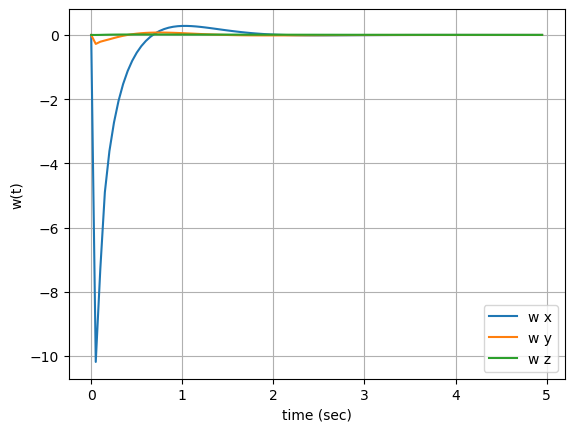

In [22]:
plt.figure()
plt.plot(thist,xhist[10:13,:-1].T)
plt.xlabel('time (sec)')
plt.ylabel('w(t)')
plt.legend(['w x','w y','w z'])
plt.grid(True)
plt.show()

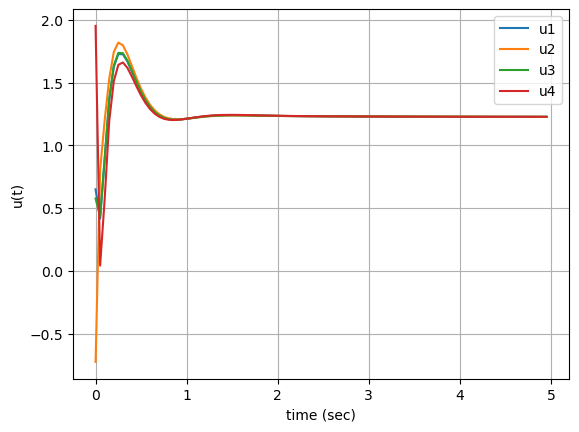

In [23]:
plt.figure()
plt.plot(thist,uhist[:,:-1].T)
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.legend(['u1','u2','u3','u4'])
plt.grid(True)
plt.show()

<hr>

### MeshCat animation

In [31]:
# meshcat animation
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
#from meshcat.animation import Animation
import time

In [32]:
# Create a new visualizer
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [55]:
base_height = 0.025
base_radius = 0.06
link_thick = 0.02
link_length = 0.46
rotor_height = 0.005
rotor_radius = 0.13
rotor_offset = link_thick
def build_quadrotor(vis):
    quadrotor = vis["quadrotor"]
    quadrotor.delete()
    base = quadrotor["base"]
    link1 = base["link1"]
    link2 = base["link2"]
    rotor1 = base["rotor1"]
    rotor2 = base["rotor2"]
    rotor3 = base["rotor3"]
    rotor4 = base["rotor4"]    
    base.set_object(g.Cylinder(height=base_height,radius=base_radius))
    link1.set_object(g.Box([link_length,link_thick,link_thick]))
    link2.set_object(g.Box([link_thick,link_thick,link_length]))
    rotor1.set_object(g.Cylinder(height=rotor_height,radius=rotor_radius))
    rotor1.set_transform(tf.translation_matrix([link_length/2,rotor_offset,0]))
    rotor2.set_object(g.Cylinder(height=rotor_height,radius=rotor_radius))
    rotor2.set_transform(tf.translation_matrix([0,rotor_offset,-link_length/2]))
    rotor3.set_object(g.Cylinder(height=rotor_height,radius=rotor_radius))
    rotor3.set_transform(tf.translation_matrix([-link_length/2,rotor_offset,0]))
    rotor4.set_object(g.Cylinder(height=rotor_height,radius=rotor_radius))
    rotor4.set_transform(tf.translation_matrix([0,rotor_offset,link_length/2]))
    base.set_transform(tf.rotation_matrix(np.pi/2,[1,0,0]))
    return base

In [56]:
quadrotor = build_quadrotor(vis)

In [125]:
def update_quadrotor(base,r,axis,angle):
    offset = np.pi/2
    base.set_transform(tf.translation_matrix(r).dot(tf.rotation_matrix(offset,[1,0,0]).dot(tf.rotation_matrix(angle,axis))))    

In [106]:
r = np.array([0,0,1])
axis = np.array([1,0,0])
angle = 0
update_quadrotor(quadrotor,r,axis,angle)

Now I need to extract information from xhist and apply to update_quadrotor().
Write a function to transform q to axis/angle

In [95]:
def q2ath(q):
    th = 2*np.arccos(q[0])
    a = np.zeros((3,))
    dv = np.sqrt(1-q[0]*q[0])
    a[0] = q[1]/dv
    a[1] = q[2]/dv
    a[2] = q[3]/dv
    return a,th
    

In [97]:
veclen = qvec.shape[1]
avec = np.zeros((3,veclen))
thvec = np.zeros((veclen))
for k in range(veclen):
    avec[:,k],thvec[k] = q2ath(qvec[:,k]) 

In [117]:
def animate_quadrotor():
    for k in range(veclen):
        update_quadrotor(quadrotor,rvec[:,k],avec[:,k],thvec[k])
        time.sleep(h)

In [134]:
animate_quadrotor()